## **Image Classification with Convolution Neural Network:**

### **Install and Import dependencies:**
We'll need TensorFlow Datasets, an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries

In [ ]:
!pip install -U tensorflow_datasets

In [3]:
from __future__ import absolute_import, division, print_function

# Import tensorflow and tensorflow dataset:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper Libraries:
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar Display:
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print(tf.__version__)


2.3.0


### **Importing Images from the Fashion MNIST dataset:**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a training dataset and test dataset.

The model is trained using train_dataset. The model is tested against test_dataset. The images are 28 × 28 arrays, with pixel values in the range [0, 255]. The labels are an array of integers, in the range [0, 9]. These correspond to the class of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandel', 'Shirt','Sneaker','Bag','Ankle boot']

# **Explore data:**
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [6]:
num_train_example = metadata.splits['train'].num_examples
num_test_example = metadata.splits['test'].num_examples

print('Number of Training examples: {}'.format(num_train_example))
print('Number of Test examples: {}'.format(num_test_example))

Number of Training examples: 60000
Number of Test examples: 10000



# **Preprocess the Data:**

Value of each pixel in image data is an integer between {0,255}. For model to work properly, we need to Normalized to the range of {0,1}.
So we create a normalized function and then apply to each image in the data set.

In [7]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The Map function applies the normalize function to each element/example in the train
# and test dataset:

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# **Explore the Preprocessed Data:**
Lets plot an Image to see what it look like:

(28, 28)


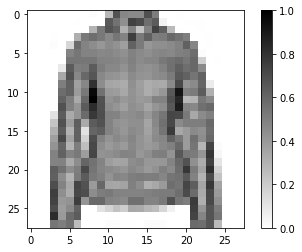

In [8]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))
print(image.shape)

# Plot the Image:
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

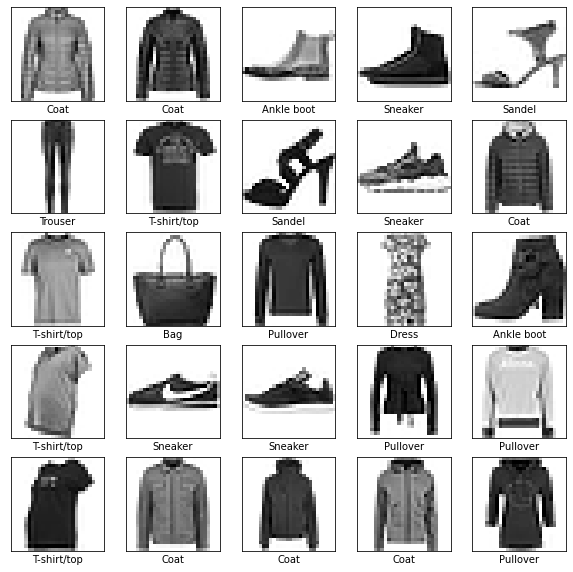

In [9]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_name[label])
  i += 1

plt.show()

## **Build the Model:**
Building the neural network requires configuring the layers of the model and then compiling the model.

**Setup the Layer:**
The basic building block of neural network is the layer. A layer extract a representation from the data fed into it.
Much of the deep learning consists of chaining togather simple layers. Most layers like tf.keras.layers.Dense, have the internal parameters which are adjusted ('learned') during training. 

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                          input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

> Note: Using `softmax` activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras` model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_example).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [16]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_example/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3945 - accuracy: 0.8578
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2541 - accuracy: 0.9063
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2109 - accuracy: 0.9227
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1817 - accuracy: 0.9330
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1544 - accuracy: 0.9434
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1286 - accuracy: 0.9522
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1070 - accuracy: 0.9599
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0910 - accuracy: 0.9673
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0738 - accuracy: 0.9729
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - lo

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_example/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 7ms/step - loss: 0.3293 - accuracy: 0.9164
Accuracy on test dataset: 0.9164000153541565


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [19]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [20]:
predictions.shape

(32, 10)

Here, the model has predicted the probability of each label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [21]:
np.argmax(predictions[0])

4

So the model is usually most confident that this image is a Shirt, or `class_names[6]`. Let's check the label:

> Indented block

In [22]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [28]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                100*np.max(predictions_array),
                                class_name[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

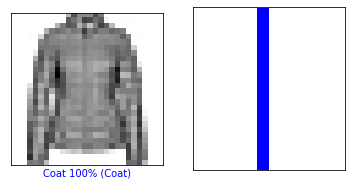

In [29]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

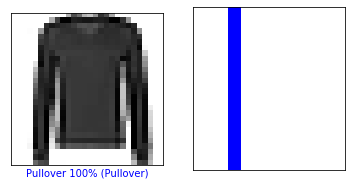

In [30]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

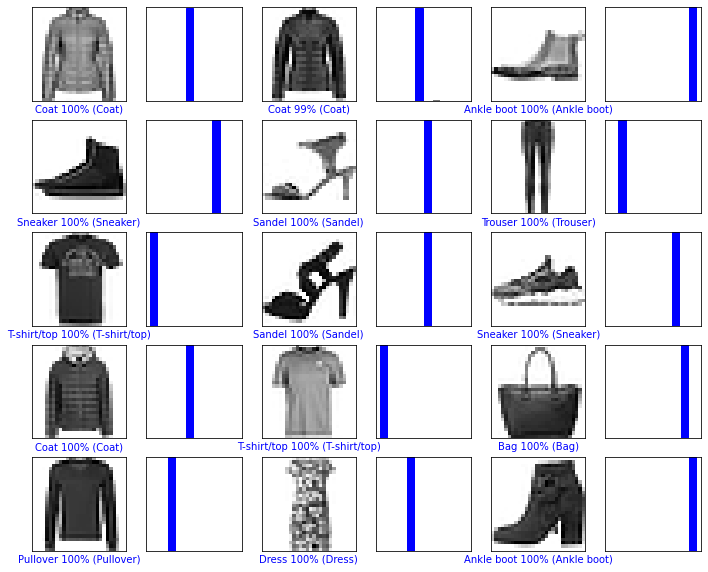

In [31]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image. 

In [32]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [33]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [34]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.3760132e-09 5.0115019e-09 9.5237468e-05 8.6418739e-09 9.9662220e-01
  3.3258725e-09 3.2824718e-03 5.9067124e-14 1.2375924e-10 5.1254752e-09]]


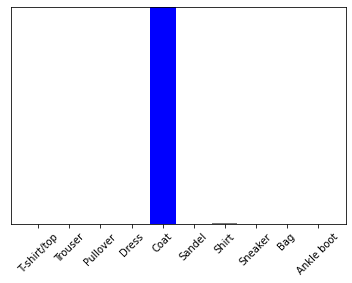

In [36]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_name, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [37]:
np.argmax(predictions_single[0])

4

And, as before, the model predicts a label of 4 (coat)